In [58]:
import os

import numpy as np
import scipy as sp
from scipy import misc, stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [59]:
MAIN_TAG = 'portrait'
DIRNAME_TAGS = '../MIRFlickr25k_tags/tags'
DIRNAME_IMAGES = '../mirflickr25k/mirflickr'

COLOR = {'red': 0,
         'green': 1,
         'blue': 2}

In [60]:
from os import listdir
from matplotlib import image
import random
# load all images in a directory
np.random.RandomState(5)
random_indexes = np.random.choice(range(25000), 250)
loaded_images = list()
image_names = list()
for i in range(250):
	# load image
	randName = random_indexes[i]
	image_names.append(randName)
	filename = 'im' + str(randName) + '.jpg'
	img_data = image.imread('../mirflickr25k/mirflickr/' + filename)
	# store loaded image
	loaded_images.append(img_data)
	print('> loaded %s %s' % (filename, img_data.shape))

> loaded im19039.jpg (309, 500, 3)
> loaded im2470.jpg (450, 500, 3)
> loaded im9429.jpg (500, 333, 3)
> loaded im13261.jpg (500, 309, 3)
> loaded im7318.jpg (500, 454, 3)
> loaded im17209.jpg (500, 367, 3)
> loaded im4046.jpg (500, 333, 3)
> loaded im17401.jpg (333, 500, 3)
> loaded im71.jpg (368, 500, 3)
> loaded im10236.jpg (310, 500, 3)
> loaded im1713.jpg (375, 500, 3)
> loaded im5498.jpg (346, 500, 3)
> loaded im22883.jpg (333, 500, 3)
> loaded im24554.jpg (335, 500, 3)
> loaded im10320.jpg (332, 500, 3)
> loaded im18000.jpg (338, 500, 3)
> loaded im14092.jpg (333, 500, 3)
> loaded im13775.jpg (375, 500, 3)
> loaded im15778.jpg (333, 500, 3)
> loaded im18970.jpg (500, 222, 3)
> loaded im3346.jpg (333, 500, 3)
> loaded im13892.jpg (375, 500, 3)
> loaded im3378.jpg (500, 375, 3)
> loaded im10403.jpg (357, 500, 3)
> loaded im8938.jpg (375, 500, 3)
> loaded im15100.jpg (500, 333, 3)
> loaded im19920.jpg (375, 500, 3)
> loaded im731.jpg (332, 500, 3)
> loaded im13813.jpg (500, 375, 3)

> loaded im15702.jpg (500, 333, 3)
> loaded im18910.jpg (375, 500, 3)
> loaded im3602.jpg (333, 500, 3)
> loaded im23463.jpg (381, 500, 3)
> loaded im8057.jpg (333, 500, 3)
> loaded im11836.jpg (466, 500, 3)


In [61]:
len(image_names)

250

In [62]:
import codecs

Y = pd.Series()
for name in image_names:
    with codecs.open(os.path.join(DIRNAME_TAGS, 'tags%d.txt' % (name,)), "r", "utf_8_sig") as file:
        set_tags = set(tag.strip() for tag in file.readlines())
        #print('tags%d.txt' % (name,), '  ',set_tags)
        Y.at[name] = int(MAIN_TAG in set_tags)
Y = pd.DataFrame(Y, columns=['target'])

In [63]:
Y['target'].value_counts()

0    241
1      8
Name: target, dtype: int64

In [64]:
Y.head()

,target
19039,0
2470,0
9429,0
13261,0
7318,0


## Static data

In [65]:
data_static = DataFrame()
num = 0
d = []
for image_name in image_names:
    image = np.array(Image.open(os.path.join(DIRNAME_IMAGES, 'im%d.jpg' % (image_name))))
    data = []
    for name, num in COLOR.items():
        a = image[:, :, num].ravel()
        data.extend([np.mean(a), np.var(a), sp.stats.skew(a), sp.stats.kurtosis(a)])
    d.append([image_name, *data])
    

data_static = pd.DataFrame.from_records(d)
data_static = data_static.rename(columns={0: 'name'}).set_index('name')

In [66]:
data_static.head()

,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,
19039,163.246201,4589.612965,-0.703461,-0.593142,158.657845,4550.585914,-0.505540,-0.848750,155.834621,4608.976475,-0.347312,-1.049672
2470,66.021067,4396.627681,0.722492,-0.565284,97.707391,4761.618616,0.097373,-1.141928,115.355747,6351.009369,-0.100433,-1.376710
9429,154.332300,6280.635210,-0.312851,-1.154056,153.774204,6638.166680,-0.387445,-1.087703,151.776282,7286.703650,-0.363965,-1.181490
13261,95.402783,3812.601546,0.839014,-0.003026,94.211010,3681.904349,0.684562,-0.384902,92.444155,3834.973923,0.410343,-0.940886
7318,50.528476,3232.238608,1.312912,1.251269,26.564692,1594.071357,1.981850,3.913727,12.199436,501.922137,2.839581,9.867090


In [67]:
data_static.shape

(250, 12)

# Learning

In [68]:
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [69]:
N = 12

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

## Static

In [71]:
X = data_static.copy()

df = Y.join(X, how='inner')
df = df.drop_duplicates()

y = df['target']
X = df.drop('target', axis=1)

Normalized confusion matrix
[[0.99107143 0.00892857]
 [0.97727273 0.02272727]]


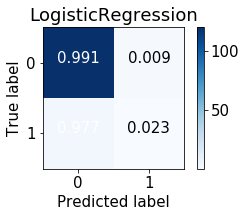

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


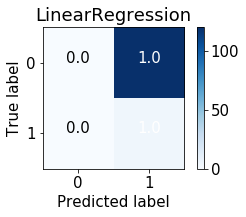

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


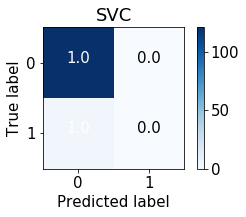

In [73]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = c()
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title=c.__name__)
    plt.savefig("static_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)

## SPAM

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


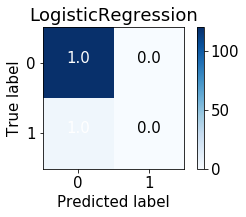

[[120.33333333   0.        ]
 [  4.66666667   0.        ]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


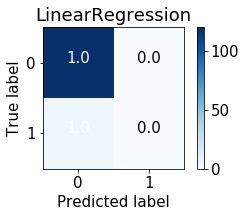

[[120.5   0. ]
 [  4.5   0. ]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


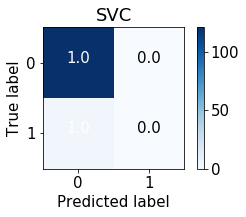

[[121.   0.]
 [  4.   0.]]


In [74]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = LinearRegression(n_jobs=-1)
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test).astype(int)
        #print(y_predict)
   
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int))) # .astype(int)
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("spam" + c.__name__ + ".png")
    plt.show()
    print(cnf_matrix)

## CCPEV

Normalized confusion matrix
[[0.99312242 0.00687758]
 [1.         0.        ]]


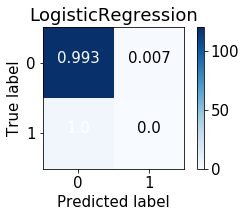

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


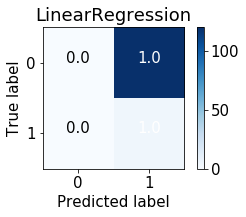

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


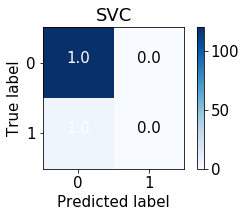

In [75]:
for c in (LogisticRegression, LinearRegression, SVC):
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls = c()
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("ccpev_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)